In [1]:
!pip install '/kaggle/input/lal-aes2-wheels/pyspellchecker-0.8.1-py3-none-any.whl'
!pip install '/kaggle/input/lal-aes2-wheels/readability-0.3.1-py3-none-any.whl'
!pip install '/kaggle/input/lal-aes2-wheels/iterative_stratification-0.1.7-py3-none-any.whl'

Processing /kaggle/input/lal-aes2-wheels/pyspellchecker-0.8.1-py3-none-any.whl
Processing /kaggle/input/lal-aes2-wheels/readability-0.3.1-py3-none-any.whl
Processing /kaggle/input/lal-aes2-wheels/iterative_stratification-0.1.7-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import yaml
import polars as pl
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
import readability
import random
import os

from types import SimpleNamespace

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from collections import Counter
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

import lightgbm as lgb

import torch

# Config

In [3]:
class CONF:
#     data_path = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"
#     extra_data_path = '/kaggle/input/lal-aes2-merge-data/non_overlapped_persuade2.csv'
#     save_path = '/kaggle/working/'
    
    seed = 42
    num_folds = 4

# Seeding

In [4]:
#https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load Data

In [5]:
# train_df = pl.read_csv('/kaggle/input/lal-aes2-create-prompt-data/train_df_with_prompt.csv')
# persuade_df = pl.read_csv('/kaggle/input/lal-aes2-create-prompt-data/nol_cleaned_persuade.csv').with_columns(kaggle_only=False)
# train_df_with_prompt = pl.concat([train_df, persuade_df], how='vertical').unique('essay_id', keep='first', maintain_order=True).with_columns(columns)

train_df_with_prompt = pl.read_csv('/kaggle/input/lal-aes2-create-tokened-text/train_combined_tokened.csv').with_columns([
    pl.col('full_text').str.split(by='\n\n').alias('paragraph')
])
# # NOL_FLAG
# nol_df = pl.read_csv('/kaggle/input/lal-aes2-create-tokened-text/nol_combined_tokened.csv').with_columns([
#     pl.col('full_text').str.split(by='\n\n').alias('paragraph')
# ])
# # NOL_FLAG

labels_map = {
    0: 'Car-free cities',
    1: '"A Cowboy Who Rode the Waves"',
    2: 'Exploring Venus',
    3: 'Facial action coding system',
    4: 'The Face on Mars',
    5: 'Driverless cars',
    6: 'Does the electoral college work?',
# # NOL_FLAG
#     # nol topics 
#     7: 'Community service',
#     8: 'Distance learning',
#     9: 'Grades for extracurricular activities',
#     10: 'Phones and driving',
#     11: 'Mandatory extracurricular activities',
#     12: 'Cell phones at school',
#     13: 'Summer projects',
#     14: 'Seeking multiple opinions',
# # NOL_FLAG
}
rev_labels_map = {v: k for k, v in labels_map.items()}

train_df_with_prompt = train_df_with_prompt.with_columns(pl.col('prompt_name').replace(rev_labels_map, return_dtype=pl.Int64))

In [6]:
# # NOL_FLAG
# nol_df = nol_df.with_columns(pl.col('prompt_name').replace(rev_labels_map, return_dtype=pl.Int64))
# nol_df = nol_df.with_columns(pl.col('kaggle_only').cast(pl.Boolean))
# train_df_with_prompt = pl.concat([train_df_with_prompt, nol_df], how='vertical')
# # NOL_FLAG

In [7]:
# checking distribution and leakage

# df = train_df_with_prompt.filter(pl.col('kaggle_only').is_not_null())
# df2 = train_df_with_prompt.filter(pl.col('kaggle_only').is_null())


# X = df['tokened_text'].to_numpy()
# y_split = df.select(['prompt_name', 'score']).to_dummies().to_numpy()
# y = df['score'].cast(pl.Float32).to_numpy()



# X2 = df2['tokened_text'].to_numpy()
# y_split2 = df2.select(['prompt_name', 'score']).to_dummies().to_numpy()
# y2 = df2['score'].cast(pl.Float32).to_numpy()


# df = df.to_pandas()
# df2 = df2.to_pandas()

# mskf = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# for fold, ((train_idx, valid_idx), (train_idx2, valid_idx2)) in enumerate(zip(mskf.split(X, y_split), mskf.split(X2, y_split2))):
#     df.loc[valid_idx, 'fold'] = fold
#     df2.loc[valid_idx2,'fold'] = fold

# Features

In [8]:
spell = SpellChecker()
def count_spelling_errors(txt):
    freq = np.array([spell[word] for word in txt.split(' ')])
    misspelled_count = len(freq[freq == 0])
    return misspelled_count

def data_preprocessing(x, data_type):
    pattern_list = [r'<.*?>', '@\w+', "'\d+", '\d+', 'http\w+', r'\s+', r'\.+', r'\,+', '\xa0']
    replace_with_list = ['', '', '', '', '', ' ', '.', ',', ' ']
    x = (
        x
        .with_columns(pl.col(data_type).str.to_lowercase())
        .with_columns(pl.col(data_type).str.replace_many(pattern_list, replace_with_list))
        .with_columns(pl.col(data_type).str.strip_chars())
    )
    
    return x

## Readability Featues

In [9]:
def measures_readability(txt):
    results = readability.getmeasures(txt, lang='en')
    return list(results['readability grades'].values())
    

def readability_preprocess(df):
    pattern_list = [r'<.*?>', '@\w+', "'\d+", '\d+', 'http\w+', r'\s+', r'\.+', r'\,+', '\xa0', '\n\n', '\'']
    replace_with_list = ['', '', '', '', '', ' ', '.', ',', ' ', ' ', "'"]
    df = (
        df
        .with_columns(pl.col('full_text').str.replace_many(pattern_list, replace_with_list).alias('cleaned_full_text'))
        .with_columns(pl.col('cleaned_full_text').str.strip_chars())
        .with_columns(pl.col('cleaned_full_text').str.split('.'))
    )
    
    return df

def readability_eng(df):

    kincaid_range = [1, 5, 11, 18]  # kincaid 0-18
    ARI_range = [1, 5, 8, 11] # ARI 0-11or_higher
    coleman_range = [1, 5, 8, 11] # Coleman-Liau 0-11orhigher
    reading_ease_range = [30, 50, 60, 70, 80, 90, 100] # FleschReadingEase 0.0-100.0
    guning_fog_range = [1, 5, 8, 11, 20] # GunningFogIndex 0-20
    lix_range = [10, 14, 19, 23, 27, 31, 35, 39, 43, 47, 51, 56] # LIX 10or_lower-56or_higher
    smog_range = [1, 5, 8, 11] # SMOGIndex 0-11or_higher
    dale_range = [4.9, 5.9, 6.9, 7.9, 8.9, 9.9] # DaleChallIndex 4.9or_lower-9.9
    
    index_table = ['rg_Kincaid', 'rg_ARI', 'rg_Coleman_Liau', 'rg_FleschReadingEase', 'rg_GunningFogIndex', 'rg_LIX', 'rg_SMOGIndex', 'rg_DaleChallIndex']
    
    df = df.explode('cleaned_full_text')
    df = df.filter(pl.col('cleaned_full_text') != '')
    df = df.with_columns(pl.col('cleaned_full_text').map_elements(measures_readability, return_dtype=pl.List(pl.Float64)).alias('read_grade'))

    df = df.with_columns(
        rg_Kincaid=pl.col('read_grade').list.get(0),
        rg_ARI=pl.col('read_grade').list.get(1),
        rg_Coleman_Liau=pl.col('read_grade').list.get(2),
        rg_FleschReadingEase=pl.col('read_grade').list.get(3),
        rg_GunningFogIndex=pl.col('read_grade').list.get(4),
        rg_LIX=pl.col('read_grade').list.get(5),
        rg_SMOGIndex=pl.col('read_grade').list.get(6),
        rg_DaleChallIndex=pl.col('read_grade').list.get(8),
    ).drop('read_grade')
    
    aggs = [
        *[pl.col('cleaned_full_text').filter(pl.col('rg_Kincaid') <= l).count().alias(f'rg_Kincaid_LE{l}') for l in kincaid_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_ARI') <= l).count().alias(f'rg_ARI_LE{l}') for l in ARI_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_Coleman_Liau') <= l).count().alias(f'rg_Coleman_Liau_LE{l}') for l in coleman_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_FleschReadingEase') <= l).count().alias(f'rg_FleschReadingEase_LE{l}') for l in reading_ease_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_GunningFogIndex') <= l).count().alias(f'rg_GunningFogIndex_LE{l}') for l in guning_fog_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_LIX') <= l).count().alias(f'rg_LIX_LE{l}') for l in lix_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_SMOGIndex') <= l).count().alias(f'rg_SMOGIndex_LE{l}') for l in smog_range],
        *[pl.col('cleaned_full_text').filter(pl.col('rg_DaleChallIndex') <= l).count().alias(f'rg_DaleChallIndex_LE{l}') for l in dale_range],
        *[pl.col(i).mean().alias(f'{i}_mean') for i in index_table],
        *[pl.col(i).std().alias(f'{i}_std') for i in index_table],
        *[pl.col(i).min().alias(f'{i}_min') for i in index_table],
        *[pl.col(i).max().alias(f'{i}_max') for i in index_table],
    ]
    df = df.group_by('essay_id', maintain_order=True).agg(aggs)
    return df

## NLTK Features

In [10]:
all_pos_tag = list(nltk.data.load('help/tagsets/upenn_tagset.pickle').keys())
all_pos_tag = [f'cnt_{tag}' for tag in all_pos_tag]

def get_tag_features(text):
    text = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(text)
    features = {}
    tense = {}
    tense["cnt_future_tense"] = len([word for word in tagged if word[1] == "MD"])
    tense["cnt_present_tense"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["cnt_past_tense"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]])
    features.update(tense)
    
    tag_count = dict(Counter([f'cnt_{word[1]}' for word in tagged]))
    for tag in all_pos_tag:
        tag_count[tag] = tag_count.get(tag, 0)
    features.update(tag_count)

    return features

def nltk_preprcess(df):
    df = data_preprocessing(df, 'full_text')
    return df

def nltk_eng(df):
    essay_ids = []
    features_list = []
    for data, _ in df.group_by(['essay_id', 'full_text'], maintain_order=True):
        features = get_tag_features(data[1])
        essay_ids.append(data[0])
        features_list.append(features)
    
    return pl.concat([pl.DataFrame({'essay_id': essay_ids}), pl.from_dicts(features_list)], how='horizontal')

## Discourse type Features

In [11]:
dt_map_ = {
    'Lead': 0,
    'Position': 1,
    'Claim': 2,
    'Evidence': 3,
    'Concluding_Statement': 4,
    'Counterclaim': 5,
    'Rebuttal': 6,
    'Repeated': -1
}

rev_dt_map_ = {v: k for k, v in dt_map_.items()}

count_dt = {
    0: '<Lead>',
    1: '<Position>',
    2: '<Claim>',
    3: '<Evidence>',
    4: '<Concluding>',
    5: '<Counterclaim>',
    6: '<Rebuttal>',
}

def dt_eng(df):
    count_cols = ['Lead_count', 'Position_count', 'Evidence_count', 'Concluding_Statement_count','Counterclaim_count', 'Rebuttal_count']
    df = (
        df
        .with_columns([
            pl.col('tokened_text').str.count_matches(count_dt[i]).alias(f'{rev_dt_map_[i]}' + '_count') for i in range(7)
        ])
        .select(['essay_id'] + count_cols)
        .with_columns(pl.sum_horizontal(count_cols).alias('dt_sum'))
    )

    return df

## Paragraph Features

In [12]:
def paragraph_preprocess(df):
    
    df = df.explode('paragraph')
    df = data_preprocessing(df, 'paragraph')
    df = (
        df
        .with_columns(pl.col('paragraph').str.replace_all(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '').alias('p_no_punctuation'))
        .with_columns(pl.col('p_no_punctuation').map_elements(count_spelling_errors, return_dtype=pl.Int64).alias('p_error_num'))
        .with_columns(pl.col('paragraph').str.len_chars().alias('p_len'))
        .with_columns(pl.col('paragraph').str.count_matches('\.').alias('p_sentence_count'))
        .with_columns(pl.col('paragraph').str.count_matches(' ').alias('p_word_count'))
    )

    return df

def paragraph_eng(df):
    p_features = ['p_error_num', 'p_len', 'p_sentence_count', 'p_word_count']
    range_list = np.arange(0, 625, 25)
    range_list2 = np.arange(0, 725, 25)
    aggs = [
        *[pl.col('paragraph').filter(pl.col('p_len') >= l).count().alias(f'p_g{l}_count') for l in range_list],
        *[pl.col('paragraph').filter(pl.col('p_len') <= l).count().alias(f'p_l{l}_count') for l in [24, 49]],
        *[pl.col(feat).max().alias(f'{feat}_max') for feat in p_features],
        *[pl.col(feat).mean().alias(f'{feat}_mean') for feat in p_features],
        *[pl.col(feat).min().alias(f'{feat}_min') for feat in p_features],
        *[pl.col(feat).sum().alias(f'{feat}_sum') for feat in p_features],
        *[pl.col(feat).first().alias(f'{feat}_first') for feat in p_features],
        *[pl.col(feat).last().alias(f'{feat}_last') for feat in p_features],
        *[pl.col(feat).kurtosis().alias(f'{feat}_kurtosis') for feat in p_features],
        *[pl.col(feat).quantile(0.25).alias(f'{feat}_q1') for feat in p_features],
        *[pl.col(feat).quantile(0.75).alias(f'{feat}_q3') for feat in p_features],
    ]
    
    df = df.group_by('essay_id', maintain_order=True).agg(aggs)

    return df

## Sentence Features

In [13]:
def sentence_preprocess(df):
    df = data_preprocessing(df, 'full_text')
    df = (
        df
        .with_columns(pl.col('full_text').str.split('.').alias('sentence'))
        .explode('sentence')
        .with_columns(pl.col('sentence').str.len_chars().alias('s_len'))
        .with_columns(pl.col('sentence').str.count_matches(' ').alias('s_word_count'))
    )
    return df

def sentence_eng(df):
    s_features = ['s_len', 's_word_count']
    range_list = np.arange(0, 350, 50)
    aggs = [
        *[pl.col('sentence').filter(pl.col('s_len') >= l).count().alias(f's_g{l}_count') for l in range_list],
        *[pl.col('sentence').filter(pl.col('s_len') <= l).count().alias(f's_l{l}_count') for l in [15]],
        *[pl.col(feat).max().alias(f'{feat}_max') for feat in s_features],
        *[pl.col(feat).mean().alias(f'{feat}_mean') for feat in s_features],
        *[pl.col(feat).min().alias(f'{feat}_min') for feat in s_features],
        *[pl.col(feat).sum().alias(f'{feat}_sum') for feat in s_features],
        *[pl.col(feat).first().alias(f'{feat}_first') for feat in s_features],
        *[pl.col(feat).last().alias(f'{feat}_last') for feat in s_features],
        *[pl.col(feat).kurtosis().alias(f'{feat}_kurtosis') for feat in s_features],
        *[pl.col(feat).quantile(0.25).alias(f'{feat}_q1') for feat in s_features],
        *[pl.col(feat).quantile(0.75).alias(f'{feat}_q3') for feat in s_features],
    ]
    
    df = df.group_by('essay_id', maintain_order=True).agg(aggs)

    return df

## Word Features

In [14]:
def word_preprocess(df):
    df = data_preprocessing(df, 'full_text')
    df = (
        df
        .with_columns(pl.col('full_text').str.split(' ').alias('word'))
        .explode('word')
        .with_columns(pl.col('word').str.len_chars().alias('w_len'))
        .filter(pl.col('w_len') != 0)
    )
    
    return df

def word_eng(df):
    range_list = np.arange(1, 21)
    aggs = [
        *[pl.col('word').filter(pl.col('w_len') >= i).count().alias(f'w_{i}_count') for i in range_list],
        pl.col('w_len').max().alias('w_len_max'),
        pl.col('w_len').mean().alias('w_len_mean'),
        pl.col('w_len').std().alias('w_len_std'),
        pl.col('w_len').quantile(0.25).alias('w_len_q1'),
        pl.col('w_len').quantile(0.50).alias('w_len_q2'),
        pl.col('w_len').quantile(0.75).alias('w_len_q3'),
    ]
    
    df = df.group_by('essay_id', maintain_order=True).agg(aggs)

    return df

## Tf-idf Features

In [15]:
def __tokenizer(x):
    return x
def __preprocessor(x):
    return x
def __preprocessor_lower(x):
    return x.lower()

In [16]:
tfidf_vec = TfidfVectorizer(
    tokenizer=__tokenizer,
    preprocessor=__preprocessor,
    token_pattern=None,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(3, 6),
    min_df=0.05,
    max_df=0.95,
    sublinear_tf=True,
)

# tfidf_vec = TfidfVectorizer(
#     #tokenizer=lambda x: x, # corrected
#     preprocessor=__preprocessor_lower,
#     #token_pattern=None,
#     strip_accents='unicode',
#     analyzer = 'char',
#     ngram_range=(3,6),
#     min_df=0.05,
#     max_df=0.95,
#     sublinear_tf=True,
# )

def get_tfidf_vec_feats(df):
    train_tfidf = tfidf_vec.fit_transform([i for i in df['full_text']])
    torch.save(tfidf_vec, 'tfidf_vec.bin')
    tfidf_dense = train_tfidf.toarray()
    tfidf_df = pl.DataFrame(tfidf_dense)
    tfidf_columns = [f'tfidf_vec_{i}' for i in range(len(tfidf_df.columns))]
    tfidf_df.columns = tfidf_columns
    tfidf_df = tfidf_df.with_columns(essay_id=df['essay_id'])
    return tfidf_df

## CountVec Features

In [17]:
count_vec = CountVectorizer(
    tokenizer=__tokenizer,
    preprocessor=__preprocessor,
    token_pattern=None,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(2, 3),
    min_df=0.10,
    max_df=0.85,
)

# count_vec = CountVectorizer(
#     #tokenizer=lambda x: x, # corrected
#     preprocessor=__preprocessor_lower,
#     #token_pattern=None,
#     strip_accents='unicode',
#     analyzer='word',
#     ngram_range=(2,3),
#     min_df=0.10,
#     max_df=0.85,
# )

def get_count_vec_feats(df):
    train_count = count_vec.fit_transform([i for i in df['full_text']])
    torch.save(count_vec, 'count_vec.bin')
    count_dense = train_count.toarray()
    count_df = pl.DataFrame(count_dense)
    count_columns = [f'count_vec_{i}' for i in range(len(count_df.columns))]
    count_df.columns = count_columns
    count_df = count_df.with_columns(essay_id=df['essay_id'])
    return count_df

## Features from deberta-v3 predict as features

In [18]:
def get_nn_feats(path_list):
    oof_df = pl.DataFrame()
    for path in path_list:
        with open(f'{path}/config.yaml') as file:
            conf = SimpleNamespace(**yaml.safe_load(file))
            
        df = pl.read_csv(f'{path}/oof_df.csv').drop('score').rename({'raw_score': f'exp{conf.exp}_preds'})
        if oof_df.is_empty():
            oof_df = df
        else:
            oof_df = oof_df.join(df, on='essay_id')
            
#     oof_df = oof_df.with_columns(pl.col(oof_df[:, 1:].columns).clip(1, 6))
    return oof_df

def get_nn_nol_feats(path_list):
    oof_df = pl.DataFrame()
    for path in path_list:
        exp_name = path[-18: -12] # expXXX
        df = pl.read_csv(path).rename({'raw_score': f'{exp_name}_preds'})
        if oof_df.is_empty():
            oof_df = df
        else:
            oof_df = oof_df.join(df, on='essay_id')
    return oof_df

def get_nn_cls_feats(path_list):
    oof_df = pl.DataFrame()
    for path in path_list:
        with open(f'{path}/config.yaml') as file:
            conf = SimpleNamespace(**yaml.safe_load(file))
        
        df = pl.read_csv(f'{path}/oof_df.csv').select([
            'essay_id',
            'pred_p_0',
            'pred_p_1',
            'pred_p_2',
            'pred_p_3',
            'pred_p_4',
            'pred_p_5',
        ]).rename({
            'pred_p_0': f'exp{conf.exp}_p_0',
            'pred_p_1': f'exp{conf.exp}_p_1',
            'pred_p_2': f'exp{conf.exp}_p_2',
            'pred_p_3': f'exp{conf.exp}_p_3',
            'pred_p_4': f'exp{conf.exp}_p_4',
            'pred_p_5': f'exp{conf.exp}_p_5',
        })
        if oof_df.is_empty():
            oof_df = df
        else:
            oof_df = oof_df.join(df, on='essay_id')
    return oof_df

# Merge Features

In [19]:
fb3_feats = pl.read_csv('/kaggle/input/lal-aes2-fb3-features/fb3_features.csv')

In [20]:
# # NOL_FLAG
# nol_fb3_feats = pl.read_csv('/kaggle/input/lal-aes2-fb3-features/nol_fb3_features.csv')
# fb3_feats = pl.concat([fb3_feats, nol_fb3_feats], how='vertical')
# # NOL_FLAG

In [21]:
# # # paragraph feats
# tmp = paragraph_preprocess(train_df_with_prompt.lazy())
# train_feats = paragraph_eng(tmp)

# # # sentence feats
# tmp = sentence_preprocess(train_df_with_prompt.lazy())
# train_feats = train_feats.join(sentence_eng(tmp), on='essay_id', how='left')

# # # word feats
# tmp = word_preprocess(train_df_with_prompt.lazy())
# train_feats = train_feats.join(word_eng(tmp), on='essay_id', how='left')

# # # discourse type feats
# train_feats = train_feats.join(dt_eng(train_df_with_prompt.lazy()), on='essay_id', how='left')

# # train_feats = dt_eng(train_df_with_prompt.lazy())

# # fb3 feats
# train_feats = train_feats.join(fb3_feats.lazy(), on='essay_id', how='inner')

# train_feats = train_feats.collect()

# readability feats (not using anymore)
# tmp = readability_preprocess(train_df_with_prompt)
# train_feats = train_feats.join(readability_eng(tmp), on='essay_id', how='left')

# pos_tag feats (not using anymore)
# tmp = nltk_preprcess(train_df_with_prompt)
# train_feats = train_feats.join(nltk_eng(tmp), on='essay_id', how='left')

# train_feats = train_feats.join(get_tfidf_vec_feats(train_df_with_prompt), on='essay_id', how='left')

# train_feats = train_feats.join(get_count_vec_feats(train_df_with_prompt), on='essay_id', how='left')

oof_feats = get_nn_feats([
#     '/kaggle/input/lal-aes2-exps/exp149',
    '/kaggle/input/lal-aes2-exps/exp181',
#     '/kaggle/input/lal-aes2-exps/exp183',
    '/kaggle/input/lal-aes2-exps/exp186',
    '/kaggle/input/lal-aes2-exps/exp187',
    '/kaggle/input/lal-aes2-exps/exp188',
#     '/kaggle/input/lal-aes2-exps/exp193',
    '/kaggle/input/lal-aes2-exps/exp197',
#     '/kaggle/input/lal-aes2-exps/exp198',
#     '/kaggle/input/lal-aes2-exps/exp199'
#     '/kaggle/input/lal-aes2-exps/exp200',
#     '/kaggle/input/lal-aes2-exps/exp201',
#     '/kaggle/input/lal-aes2-exps/exp202',
#     '/kaggle/input/lal-aes2-exps/exp203',
#     '/kaggle/input/lal-aes2-exps/exp204',
])

# # NOL_FLAG
# oof_nol_feats = get_nn_nol_feats([
#     '/kaggle/input/lal-aes2-nol-oof/exp149_nol_oof.csv',
#     '/kaggle/input/lal-aes2-nol-oof/exp181_nol_oof.csv'
# ])
# oof_feats = pl.concat([oof_feats, oof_nol_feats], how='vertical')
# # NOL_FLAG

# train_feats = train_feats.join(oof_feats, on='essay_id', how='left')

train_feats = oof_feats

# oof_cls_feats = get_nn_cls_feats([
#     '/kaggle/input/lal-aes2-exps/exp196'
# ])

# train_feats = train_feats.join(oof_cls_feats, on='essay_id', how='left')

train_feats = train_feats.join(train_df_with_prompt.select(['essay_id', 'score', 'prompt_name', 'kaggle_only']), on='essay_id')

In [22]:
train_feats

essay_id,exp181_preds,exp186_preds,exp187_preds,exp188_preds,exp197_preds,score,prompt_name,kaggle_only
str,f64,f64,f64,f64,f64,i64,i64,bool
"""000d118""",2.47367,2.5271258,2.71662,1.8557805,1.9190164,3,0,false
"""000fe60""",3.0946693,3.0378978,3.172372,2.6304553,3.0513916,3,4,true
"""001ab80""",4.447447,4.204406,4.3816533,4.3580723,4.478097,4,5,true
"""001bdc0""",3.5195177,3.9150782,3.6772397,3.7631073,3.6433682,4,2,true
"""002ba53""",2.8116236,2.9343262,2.863635,2.0843964,2.8808274,3,6,false
…,…,…,…,…,…,…,…,…
"""ffd378d""",1.9638057,1.6959708,1.9854527,2.0988202,2.0210757,2,2,true
"""ffddf1f""",4.060088,4.0324507,3.997423,3.8002462,4.3138433,4,3,false
"""fff016d""",1.8464158,2.0927148,2.0180078,2.170321,2.1402693,2,1,false


# Metrics

In [23]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

# a = 2.998
# b = 1.092

# (2.948402380539666, 1.0918134361390224)

a = 2.948
b = 1.092

# Train

In [24]:
def run_training(conf, df_, selected_feats=[]):
    seed_everything(42)
    predictions = []
    raw_predictions = []
    predictions_id = []
    kappa_scores = []
    f1_scores = []
    models = []
    
    callbacks = [
        lgb.log_evaluation(period=25),
        lgb.early_stopping(stopping_rounds=75, first_metric_only=True)
    ]
    df = df_.filter(pl.col('kaggle_only').is_not_null())
#     # NOL_FLAG
#     df2 = df_.filter(pl.col('kaggle_only').is_null())
#     # NOL_FLAG

    target_cols = df.drop(['essay_id', 'score', 'prompt_name', 'kaggle_only']).columns
    
# #     X = df[target_cols].cast(pl.Float32).to_numpy()
#     X = df[selected_feats].cast(pl.Float32).to_numpy()
#     y_valid = df['score'].cast(pl.Int32).to_numpy()
#     y_split = df.select(['prompt_name', 'score']).to_dummies().to_numpy()
#     y = df['score'].cast(pl.Float32).to_numpy() - a
#     oof = df['score'].cast(pl.Int32).to_numpy()
#     essay_id = df['essay_id']
#     hold_df = df[['essay_id', 'score']]
    
############################ pandas
    if selected_feats:
        print('Using selected feats')
        X = df[selected_feats].cast(pl.Float32).to_pandas()
    else:
        print('Using all feats')
        X = df[target_cols].cast(pl.Float32).to_pandas()
    y_valid = df['score'].cast(pl.Int32).to_pandas()
    y_split = df.select(['prompt_name', 'score']).to_dummies().to_pandas()
    y = df['score'].cast(pl.Float32).to_pandas() - a
    oof = df['score'].cast(pl.Int32).to_pandas()
    essay_id = df['essay_id']
    hold_df = df[['essay_id', 'score']]
############################ pandas

    
#     # NOL_FLAG
# #     target_cols2 = df2.drop(['essay_id', 'score', 'prompt_name', 'kaggle_only']).columns
#     X2 = df2[selected_feats].cast(pl.Float32).to_numpy()
#     y_valid2 = df2['score'].cast(pl.Int32).to_numpy()
#     y_split2 = df2.select(['prompt_name', 'score']).to_dummies().to_numpy() # must be in this order
#     y2 = df2['score'].cast(pl.Float32).to_numpy() - a
#     oof2 = df2['score'].cast(pl.Int32).to_numpy()
#     essay_id2 = df2['essay_id']
#     hold_df2 = df2[['essay_id', 'score']]
#     # NOL_FLAG
    

    mskf = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    for fold, (train_idx, valid_idx) in enumerate(mskf.split(X, y_split)):
############################ pandas
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        y_valid_fold_int = y_valid[valid_idx] # pd.Series
        essay_id_valid_fold = essay_id[valid_idx].to_list() # pd.Series
########################### pandas 

#         X_train_fold, X_valid_fold = X[train_idx], X[valid_idx]
#         y_train_fold, y_valid_fold = y[train_idx], y[valid_idx]
        
#         y_valid_fold_int = y_valid[valid_idx]
#         essay_id_valid_fold = essay_id[valid_idx].to_list()

#     # NOL_FLAG
#     for fold, ((train_idx, valid_idx), (train_idx2, valid_idx2)) in enumerate(zip(mskf.split(X, y_split), mskf.split(X2, y_split2))):
#         X_train_fold, X_valid_fold = np.concatenate([X[train_idx], X2[train_idx2]]), np.concatenate([X[valid_idx], X2[valid_idx2]])
#         y_train_fold, y_valid_fold = np.concatenate([y[train_idx], y2[train_idx2]]), np.concatenate([y[valid_idx], y2[valid_idx2]])
#         y_valid_fold_int = np.concatenate([y_valid[valid_idx], y_valid2[valid_idx2]])
#         essay_id_valid_fold = essay_id[valid_idx].to_list() + essay_id2[valid_idx2].to_list()
#     # NOL_FLAG
        
        print(f'Fold: {fold}')
        
        model = lgb.LGBMRegressor(
            objective = qwk_obj,
            metrics='None',
            learning_rate=0.05,
            max_depth=5,
            num_leaves=10,
            colsample_bytree=0.3,
            reg_alpha=0.7,
            reg_lambda=0.1,
            n_estimators=700,
            random_state=42,
            extra_trees=True,
            class_weight='balanced',
            verbosity=-1,
        )
        
        predictor = model.fit(
            X_train_fold,
            y_train_fold,
            eval_names=['train', 'valid'],
            eval_set=[
                (X_train_fold, y_train_fold),
                (X_valid_fold, y_valid_fold)
            ],
            eval_metric=quadratic_weighted_kappa,
            callbacks=callbacks
        )
        
#         predictions_fold = predictor.predict(X_valid_fold)
        predictions_fold = predictor.predict(X_valid_fold, validate_features=True)
        models.append(predictor)
        predictions_fold = predictions_fold + a
        raw_predictions.append(predictions_fold)
        predictions_fold = np.rint(predictions_fold).clip(1, 6)
        predictions.append(predictions_fold)
        predictions_id.append(essay_id_valid_fold)
        
        f1_fold = f1_score(y_valid_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)
        
        kappa_fold = cohen_kappa_score(y_valid_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)
        
        cm = confusion_matrix(y_valid_fold_int, predictions_fold)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()
        
        print(f'F1: {f1_fold}')
        print(f'QWK: {kappa_fold}')
        
    mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)
    
    preds_df = pd.DataFrame({
        'essay_id': np.concatenate(predictions_id),
        'raw_preds': np.concatenate(raw_predictions),
        'preds': np.rint(np.concatenate(predictions)).clip(1, 6).astype(int)
    })
    preds_df = preds_df.merge(hold_df.to_pandas(), on='essay_id', how='inner').sort_values('essay_id').reset_index(drop=True)
#     # NOL_FLAG
#     preds_df = preds_df.merge(pl.concat([
#         hold_df, hold_df2
#     ], how='vertical').to_pandas(), on='essay_id', how='inner').sort_values('essay_id').reset_index(drop=True)
#     # NOL_FLAG
    
    # rename to align with nn oof_df
    preds_df.drop(['preds', 'score'], axis=1).rename({'raw_preds': 'raw_score'}, axis=1).to_csv('oof_df.csv', index=False)

    preds_col, scores_col = preds_df['preds'].values, preds_df['score'].values
    oof_kappa = cohen_kappa_score(scores_col, preds_col, weights='quadratic')
    oof_f1 = f1_score(scores_col, preds_col, average='weighted')
    
    all_cm = confusion_matrix(scores_col, preds_col)
    all_disp = ConfusionMatrixDisplay(all_cm)
    all_disp.plot()
    plt.show()
    
    print(f'feats_len: {len(selected_feats)}')
    print(f'Mean F1: {mean_f1_score}')
    print(f'Mean QWK: {mean_kappa_score}')
    print(f'OOF F1: {oof_f1}')
    print(f'OOF QWK: {oof_kappa}')
    
    torch.save(models, 'models.bin')

Using all feats
Fold: 0
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

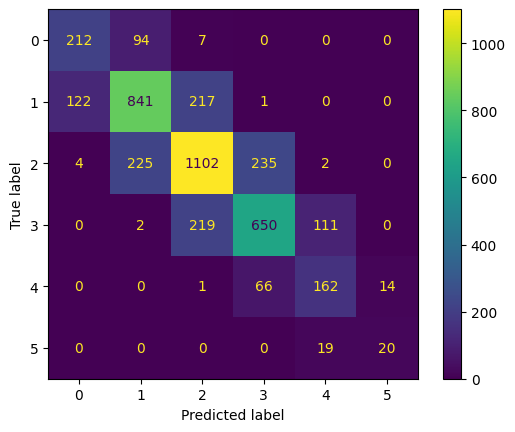

F1: 0.6910612970734898
QWK: 0.8561952458150275
Fold: 1
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

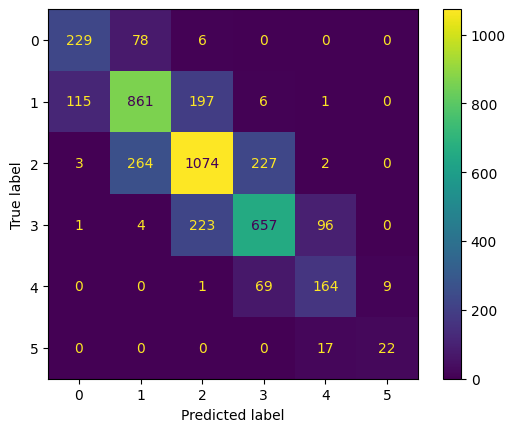

F1: 0.6952447615475428
QWK: 0.8550159685804133
Fold: 2
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

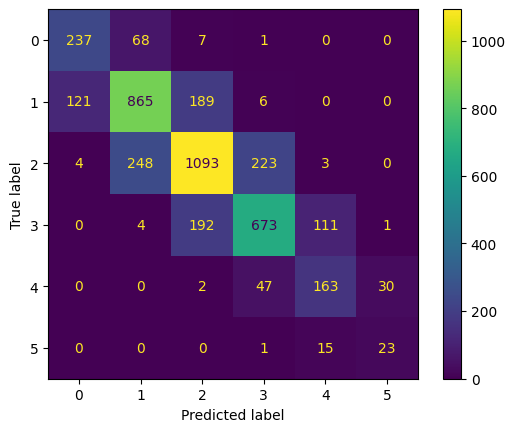

F1: 0.7067959478091712
QWK: 0.8627996249028755
Fold: 3
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 75 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

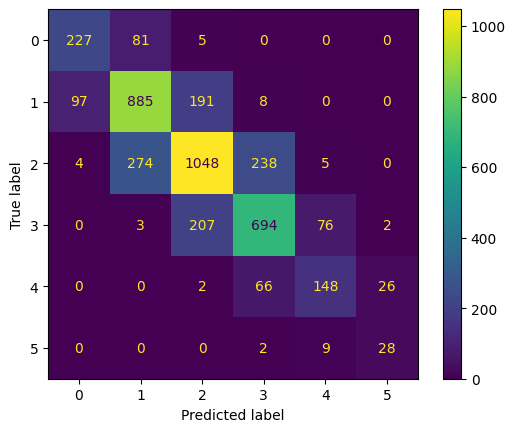

F1: 0.7002854792044786
QWK: 0.8572077798290156


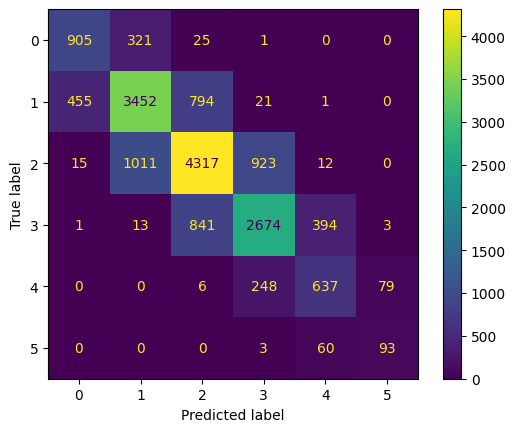

feats_len: 0
Mean F1: 0.6983468714086707
Mean QWK: 0.857804654781833
OOF F1: 0.698355729716913
OOF QWK: 0.857840072646403


In [25]:
# run_training(CONF, train_feats, selected_feats)

run_training(CONF, train_feats)

In [26]:
# + 197 + 202
# seed 42
# Mean F1: 0.7038607010476543
# Mean QWK: 0.8584876345918298
# OOF F1: 0.7038690902301313
# OOF QWK: 0.8585114100023106

# seed 0
# Mean F1: 0.7052246686132919
# Mean QWK: 0.8589432203155307
# OOF F1: 0.7052563182371724
# OOF QWK: 0.8589846727318117

# seed 99
# Mean F1: 0.7031570789236412
# Mean QWK: 0.8571605181363458
# OOF F1: 0.7032492642259396
# OOF QWK: 0.8571983905225505

# seed 2024
# Mean F1: 0.7045789256134258
# Mean QWK: 0.8579322435235018
# OOF F1: 0.7046169387732615
# OOF QWK: 0.8579480794525983

# sum([0.8585114100023106, 0.8589846727318117, 0.8571983905225505, 0.8579480794525983])/4
# 0.8581606381773178

In [27]:
# + 197
# seed 42
# Mean F1: 0.7059993850568814
# Mean QWK: 0.8590750953601127
# OOF F1: 0.7060932924374089
# OOF QWK: 0.8591147685260334

# seed 0
# Mean F1: 0.703797210850595
# Mean QWK: 0.8580590184733445
# OOF F1: 0.7038517017910553
# OOF QWK: 0.8580850887507577

# seed 99
# Mean F1: 0.7021824032502102
# Mean QWK: 0.8578065894972161
# OOF F1: 0.7022216918492843
# OOF QWK: 0.8578351009921916

# seed 2024
# Mean F1: 0.7033645407674128
# Mean QWK: 0.8586146798634513
# OOF F1: 0.7033801002036327
# OOF QWK: 0.8586363463080648

# sum([0.8591147685260334, 0.8580850887507577, 0.8578351009921916, 0.8586363463080648])/4
# 0.8584178261442619